In [6]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part53_othellogpt"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

extract_dir = '/root/ARENA_3.0/chapter1_transformer_interp/exercises/extracted_files'
sys.path.append(extract_dir)
sys.path.append("/root/miniconda3/envs/arena-env/lib/python3.11/site-packages")
from huggingface_hub import hf_hub_download
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line

MAIN = __name__ == "__main__"

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)


In [25]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model = AutoModelForCausalLM.from_pretrained("adamkarvonen/8LayerChessGPT2")
model.to(device)

# Path to the model file (adjust the file name as needed)
autoencoder_group_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/")
autoencoder_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/trainer4/ae.pt")

# Load the model weights (assuming the model definition is available)
autoencoder = torch.load(autoencoder_path)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
train_dataset_name = f"chess_train_dataset.pkl"

if os.path.exists(train_dataset_name):
    print("Loading statistics aggregation dataset")
    with open(train_dataset_name, "rb") as f:
        train_data = pickle.load(f)
else:
    train_data = eval_sae.construct_dataset(
        False,
        [chess_utils.board_to_check_state],
        1000,
        split="train",
        device=device,
        precompute_dataset=True,
    )
    with open(train_dataset_name, "wb") as f:
        pickle.dump(train_data, f)
sae = AutoEncoder.from_pretrained(Path(autoencoder_path), device=device)

Loading statistics aggregation dataset


In [139]:
games_close_to_check = []

for i, pgn in enumerate(train_data['decoded_inputs']):
    for j in range(len(pgn)):
        if pgn[j] == '+':
            games_close_to_check.append((i, j))

print(len(games_close_to_check))
print(games_close_to_check[0])
print(train_data['decoded_inputs'][games_close_to_check[0][0]][games_close_to_check[0][1]])

train_data['board_to_check_state'].nonzero()[:20]



1217
(3, 71)
+


tensor([[  3,  72,   0,   0,   0],
        [  3,  73,   0,   0,   0],
        [  3,  74,   0,   0,   0],
        [  3,  75,   0,   0,   0],
        [  4, 199,   0,   0,   0],
        [  4, 200,   0,   0,   0],
        [  4, 201,   0,   0,   0],
        [  4, 202,   0,   0,   0],
        [  4, 203,   0,   0,   0],
        [  4, 204,   0,   0,   0],
        [  4, 205,   0,   0,   0],
        [  4, 235,   0,   0,   0],
        [  4, 236,   0,   0,   0],
        [  4, 237,   0,   0,   0],
        [  4, 238,   0,   0,   0],
        [  4, 239,   0,   0,   0],
        [  4, 240,   0,   0,   0],
        [  4, 241,   0,   0,   0],
        [  7,  20,   0,   0,   0],
        [  7,  21,   0,   0,   0]], device='cuda:0')

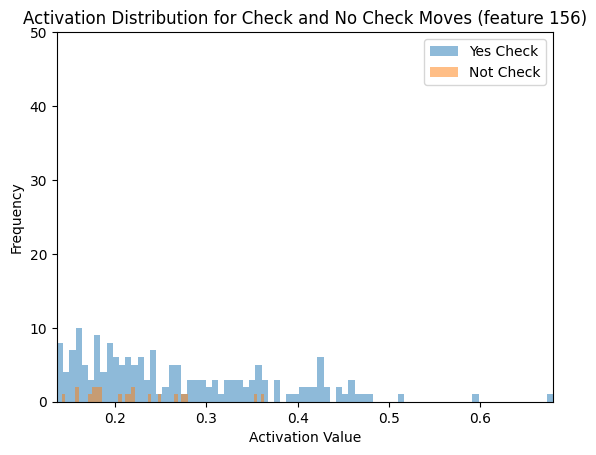

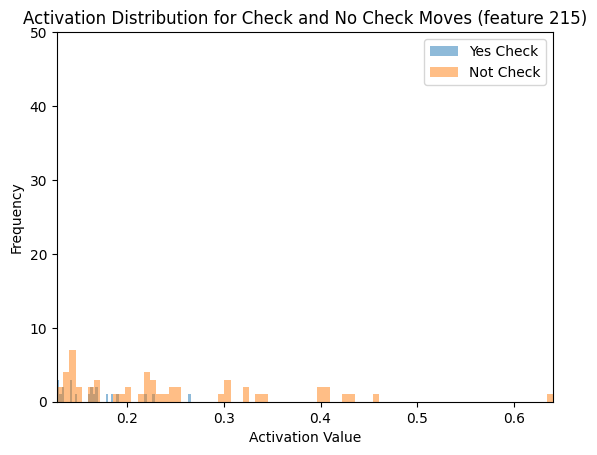

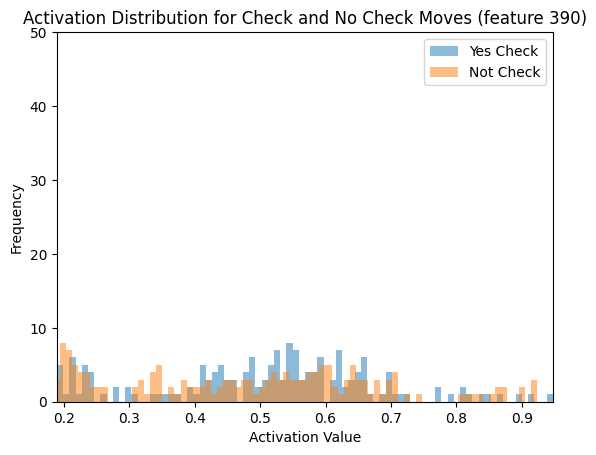

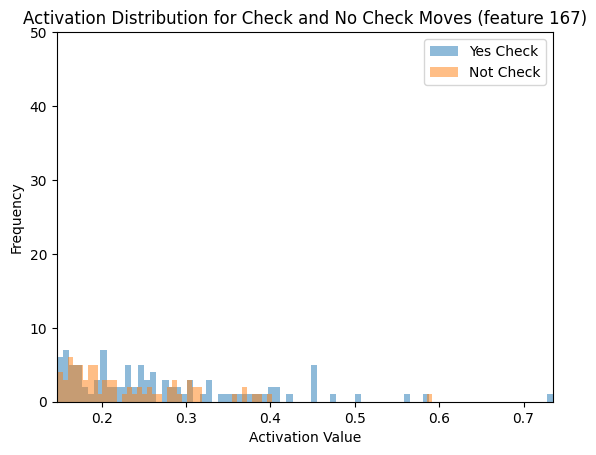

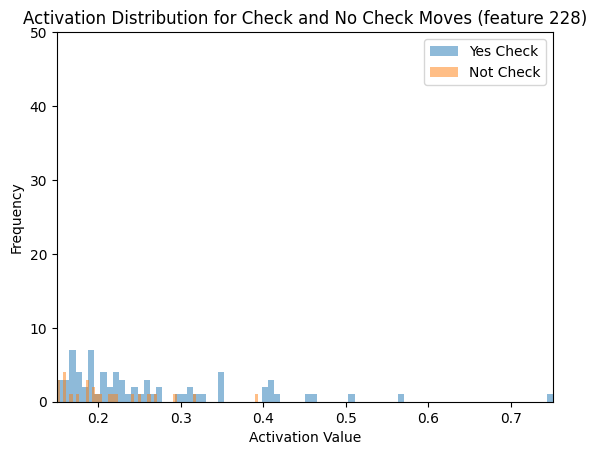

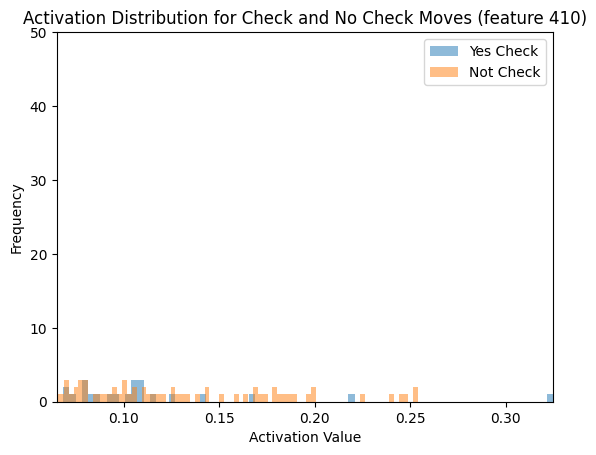

In [136]:
t.set_grad_enabled(False)
for feature_number in [156, 215, 390, 167, 228, 410]:
    num_samples = 2000
    model_activations = []
    def get_activation(name):
        def hook(model, input, output):
            model_activations.append(output.detach())
        return hook
    pgn_index_list = t.randint(10, 1000, (num_samples,))
    move_index_list = t.randint(10, 256, (num_samples,))
    yes_check_activations = []
    not_check_activations = []
    max_activation = 0
    for pgn_idx, move_idx in zip(pgn_index_list, move_index_list):
        encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
        activation_handle=model.transformer.h[5].mlp.register_forward_hook(get_activation(f"mlp_block_{5}"))
        model(t.tensor(encoded_input).to(device)).logits[-1]
        activation_handle.remove()
        chess_gpt_activations = model_activations[0][0][-1]
        model_activations = []
        sae_activations = sae.encode(chess_gpt_activations)
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activation = max(max_activation, this_feature_activation)
        if train_data['board_to_check_state'][pgn_idx, move_idx, 0, 0, 0] == 0:
            not_check_activations.append(this_feature_activation)
        else:
            yes_check_activations.append(this_feature_activation)
    for pgn_idx, move_idx, _, _, _ in train_data['board_to_check_state'].nonzero()[:num_samples]:
        encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
        activation_handle=model.transformer.h[5].mlp.register_forward_hook(get_activation(f"mlp_block_{5}"))
        model(t.tensor(encoded_input).to(device)).logits[-1]
        activation_handle.remove()
        chess_gpt_activations = model_activations[0][0][-1]
        model_activations = []
        sae_activations = sae.encode(chess_gpt_activations)
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activation = max(max_activation, this_feature_activation)
        if train_data['board_to_check_state'][pgn_idx, move_idx, 0, 0, 0] == 0:
            not_check_activations.append(this_feature_activation)
        else:
            yes_check_activations.append(this_feature_activation)
        
        

    multiplier = 0.2
    plt.hist(yes_check_activations, bins=100, alpha=0.5, label='Yes Check')
    plt.hist(not_check_activations, bins=100, alpha=0.5, label='Not Check')
    plt.xlim(multiplier * max_activation, max_activation)
    plt.ylim(0, 50)
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.title(f'Activation Distribution for Check and No Check Moves (feature {feature_number})')
    plt.legend(loc='upper right')
    plt.show()








In [142]:
train_data['encoded_inputs'][0]
train_data['board_to_check_state'][0].shape
len(train_data['encoded_inputs'][0])

256

In [134]:


total_yeses_over_activation = len([x for x in yes_check_activations if x > max_activation * multiplier]) 
total_nos_over_activation = len([x for x in not_check_activations if x > max_activation * multiplier]) 

print(total_yeses_over_activation/(total_yeses_over_activation + total_nos_over_activation))
print(total_yeses_over_activation, total_nos_over_activation)


0.5138461538461538
167 158


In [135]:
p_act_yes = total_yeses_over_activation/len(yes_check_activations)
p_yes = len(train_data['board_to_check_state'].nonzero())/len(train_data['board_to_check_state'].flatten())

p_act_no = total_nos_over_activation/len(not_check_activations)
p_no = 1 - p_yes

p_act = p_act_yes * p_yes + p_act_no * p_no

p_yes_act = p_act_yes * p_yes / p_act
print("p_act_yes: ", round(p_act_yes, 3), "p_yes: ", round(p_yes, 3), "p_act_no: ", round(p_act_no, 3), "p_no: ", round(p_no, 3), "p_act: ", round(p_act, 3), "p_yes_act: ", round(p_yes_act, 3))

p_act_yes:  0.081 p_yes:  0.026 p_act_no:  0.081 p_no:  0.974 p_act:  0.081 p_yes_act:  0.026


In [122]:
train_data['board_to_check_state'].nonzero()[:10]

tensor([[  3,  72,   0,   0,   0],
        [  3,  73,   0,   0,   0],
        [  3,  74,   0,   0,   0],
        [  3,  75,   0,   0,   0],
        [  4, 199,   0,   0,   0],
        [  4, 200,   0,   0,   0],
        [  4, 201,   0,   0,   0],
        [  4, 202,   0,   0,   0],
        [  4, 203,   0,   0,   0],
        [  4, 204,   0,   0,   0]], device='cuda:0')